In [1]:
import sys
path='/home/tomas/Ulmer-Berechnung/Deprecated-ada-max-ent/AdaptMaxEnt-main'

sys.path.insert(1, path) 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as linalg

from IPython.display import display_latex
from alpsqutip.geometry import graph_from_alps_xml, list_graph_in_alps_xml
from alpsqutip.alpsmodels import list_operators_in_alps_xml,model_from_alps_xml
from alpsqutip.utils import eval_expr
from alpsqutip.model import SystemDescriptor

import qutip as qutip
from typing import Callable, Optional, Tuple
models_lib_file = path+"/alpsqutip/lib/models.xml"
lattice_lib_file = path+"/alpsqutip/lib/lattices.xml"

In [3]:
from alpsqutip.proj_evol import safe_exp_and_normalize
from alpsqutip.operators.states.meanfield import (one_body_from_qutip_operator, 
                                                  project_to_n_body_operator, 
                                                  self_consistent_quadratic_mfa)

from alpsqutip import restricted_maxent_toolkit as me ## custom library including basic linear algebra functions 

In [24]:
params={}

params['size']=6
params['Jx']=1.; params['Jy'] = .75*params['Jx']; params['Jz']=1.05*params['Jx']; beta=1.

from scipy.optimize import root, fsolve
Ffactor=np.real(max(np.roots(np.poly1d([1, 0, -(params['Jx']*params['Jy']+params['Jx']*params['Jy']+params['Jy']*params['Jz']), 
                           -2*params['Jx']*params['Jy']*params['Jz']]))))
chi_y=fsolve(lambda x,y: x*np.arcsinh(x)-np.sqrt(x**2+1)-y, 1e-1, args=(0))[0]
vLR=4*Ffactor*chi_y
timespan=np.linspace(.0, 850.1/vLR,100)

In [57]:
Lx = params['Lx']  # Number of columns
Ly = params['Ly']  # Number of rows

system = SystemDescriptor(
    model=model_from_alps_xml(models_lib_file, "spin"),
    graph=graph_from_alps_xml(lattice_lib_file, "open chain lattice", parms={"L": Lx * Ly, "a": 1}),
    parms={"h": 0, "J": params['Jx']}
)

# Define site indexing
sites = [f"1[{a + Lx * b}]" for b in range(Ly) for a in range(Lx)]

# Define spin operators as lists
sx_ops = [system.site_operator("Sx", site) for site in sites]
sy_ops = [system.site_operator("Sy", site) for site in sites]
sz_ops = [system.site_operator("Sz", site) for site in sites]

# List of interaction terms
H_terms = []

for b in range(Ly):
    for a in range(Lx):
        index = a + Lx * b  # Flattened index
       
        # Right neighbor
        if a + 1 < Lx:
            neighbor = index + 1
            H_terms.append(params['Jx'] * (sx_ops[index] * sx_ops[neighbor] +
                                           sy_ops[index] * sy_ops[neighbor] +
                                           sz_ops[index] * sz_ops[neighbor]))

        # Bottom neighbor
        if b + 1 < Ly:
            neighbor = index + Lx
            H_terms.append(params['Jy'] * (sx_ops[index] * sx_ops[neighbor] +
                                           sy_ops[index] * sy_ops[neighbor] +
                                           sz_ops[index] * sz_ops[neighbor]))

        # Diagonal neighbor (depends on row parity)
        if b + 1 < Ly:
            if b % 2 == 0 and a + 1 < Lx:  # Even row → diagonal bottom-right
                neighbor = index + Lx + 1
            elif b % 2 == 1 and a - 1 >= 0:  # Odd row → diagonal bottom-left
                neighbor = index + Lx - 1
            else:
                continue

            H_terms.append(params['Jz'] * (sx_ops[index] * sx_ops[neighbor] +
                                           sy_ops[index] * sy_ops[neighbor] +
                                           sz_ops[index] * sz_ops[neighbor]))

# Convert list to Hamiltonian sum
H0 = sum(H_terms)

# Identity and global Sz operators
Iz = system.global_operator("Sz")
idop = system.site_operator("identity", sites[0])

KeyError: 'Lx'

In [25]:
system=SystemDescriptor(
    model=model_from_alps_xml(models_lib_file, "spin"),
    graph=graph_from_alps_xml(lattice_lib_file, "open chain lattice", parms={"L":params['size'], "a":1}),
    parms={"h":0,"J":params['Jx']}
)

sites=[s for s in system.sites]
sx_ops=[system.site_operator("Sx", '1[' + str(a) + ']') for a in range(len(system.sites))]
sy_ops=[system.site_operator("Sy", '1[' + str(a) + ']') for a in range(len(system.sites))]
sz_ops=[system.site_operator("Sz", '1[' + str(a) + ']') for a in range(len(system.sites))]

H = (params['Jx']*sum(sx_ops[i]*sx_ops[i+1] for i in range(params['size']-1)) 
     + params['Jy']*sum(sy_ops[i]*sy_ops[i+1] for i in range(params['size']-1))
     +params['Jz']*sum(sz_ops[i]*sz_ops[i+1] for i in range(params['size']-1)))
idop=system.site_operator("identity", sites[0])

Iz = system.global_operator("Sz")

### Global observable Sz evolution

In [26]:
### Initial state ### 

## |SZ> state
HBB0=[idop]+[sz for sz in sz_ops]

phi0 = np.array([.0] + [-10. for i in range(len(sz_ops))])
K0 = me.Kstate_from_phi_basis(phi0, HBB0)
sigma0 = me.safe_exp_and_normalize(K0)[0]
phi0[0] = np.log(sigma0.tr())
K0 = me.Kstate_from_phi_basis(phi0, HBB0)
sigma0 = me.safe_exp_and_normalize(K0)[0]
[(sigma0 * op).tr() for op in sz_ops]

[0.4999546021312976,
 0.4999546021312976,
 0.49995460213129767,
 0.4999546021312976,
 0.4999546021312976,
 0.49995460213129767]

In [98]:
def adaptive_Heisenberg_simulation(generator, rho0, tlist, simulation_params):
    local_bound_error=[]; saved_cut_times_index=[]; 
    no_acts=[0]; expectation_values=[]; 
    local_t_value=.0
    
    local_seed_op=simulation_params["obs"]; local_ell=simulation_params["depth"]; 
    local_tol=simulation_params["tol"]; local_nmax=simulation_params["nmax"]
    
    sp_local=me.fetch_covar_scalar_product(sigma=rho0)
    HBB_ell_act=me.build_Hierarch(generator=generator, seed_op=local_seed_op, deep=local_ell)
    orth_basis_act=me.orthogonalize_basis(basis=HBB_ell_act, sp=sp_local)
    Hij_tensor_act=me.fn_Hij_tensor(generator=generator, basis=orth_basis_act, sp=sp_local)
    
    phi0_proj_act=me.project_op(local_seed_op, orth_basis_act, sp_local)
    phi_at_timet=[phi0_proj_act]; expectation_value=[qutip.expect(local_seed_op, rho0)]
    
    for t in timespan[1:]:
        phi_local=np.real( linalg.expm(Hij_tensor_act * (t-local_t_value)) @ phi0_proj_act )
        local_seed_op = me.Kstate_from_phi_basis(phi=-phi_local, basis=orth_basis_act)
        expectation_values.append(qutip.expect(local_seed_op, rho0))
        
        local_bound_error.append(
            me.m_th_partial_sum(phi=phi_local, m=3)/me.m_th_partial_sum(phi=phi_local, m=0)
        )
        
        if abs(local_bound_error[-1]) >= local_tol:
            no_acts.append(no_acts[-1] + 1)
            if list(timespan).index(t)%30==0:
                print("Actualization at time t=", t)
            local_t_value=t; saved_cut_times_index.append(list(timespan).index(t))
            
            HBB_ell_act=me.build_Hierarch(generator=generator, seed_op=local_seed_op,
                                                          deep=local_ell)
            HBB_ell_act=[project_to_n_body_operator(one_body_from_qutip_operator(op), nmax=local_nmax)
                             for op in HBB_ell_act]
            
            HBB_ell_act=[op.to_qutip() for op in HBB_ell_act]
            orth_basis_act=me.orthogonalize_basis(basis=HBB_ell_act, sp=sp_local)
            Hij_tensor_act=me.fn_Hij_tensor(generator=generator, basis=orth_basis_act, sp=sp_local)
    
            phi0_proj_act=me.project_op(local_seed_op, orth_basis_act, sp_local)
        else:
            no_acts.append(no_acts[-1])
    
    return phi_at_timet, expectation_values

In [118]:
simulation_params={}
simulation_params["obs"]=Iz.to_qutip(); simulation_params["depth"]=4; 
simulation_params["tol"]=2e-2; simulation_params["nmax"]=3

phi_at_timet, expt_vals=adaptive_Heisenberg_simulation(generator=H.to_qutip(), 
                                                      rho0=sigma0.to_qutip(),
                                                      tlist=timespan, 
                                                      simulation_params=simulation_params)

Actualization at time t= 23.965427565855354
Actualization at time t= 47.93085513171071
Actualization at time t= 71.89628269756606


In [117]:
simulation_params={}
simulation_params["obs"]=Iz.to_qutip(); simulation_params["depth"]=3; 
simulation_params["tol"]=1e-3; simulation_params["nmax"]=2

phi_at_timet2, expt_vals2=adaptive_Heisenberg_simulation(generator=H.to_qutip(), 
                                                      rho0=sigma0.to_qutip(),
                                                      tlist=timespan, 
                                                      simulation_params=simulation_params)

Actualization at time t= 23.965427565855354
Actualization at time t= 47.93085513171071
Actualization at time t= 71.89628269756606


In [119]:
simulation_params={}
simulation_params["obs"]=Iz.to_qutip(); simulation_params["depth"]=6; 
simulation_params["tol"]=1e-4; simulation_params["nmax"]=6

phi_at_timet3, expt_vals3=adaptive_Heisenberg_simulation(generator=H.to_qutip(), 
                                                      rho0=sigma0.to_qutip(),
                                                      tlist=timespan, 
                                                      simulation_params=simulation_params)

Actualization at time t= 23.965427565855354
Actualization at time t= 47.93085513171071
Actualization at time t= 71.89628269756606


In [106]:
res_exact=qutip.mesolve(H=H.to_qutip(), tlist=timespan, rho0=sigma0.to_qutip(), e_ops=[Iz.to_qutip()])

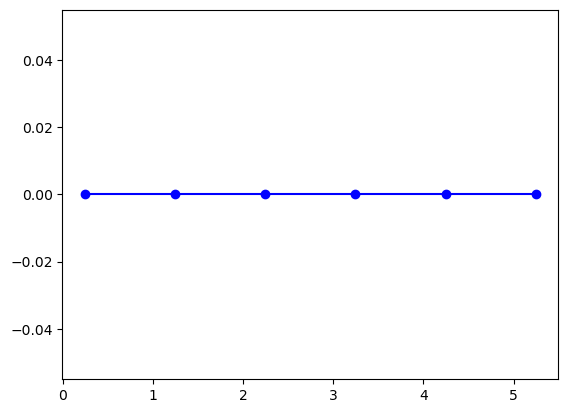

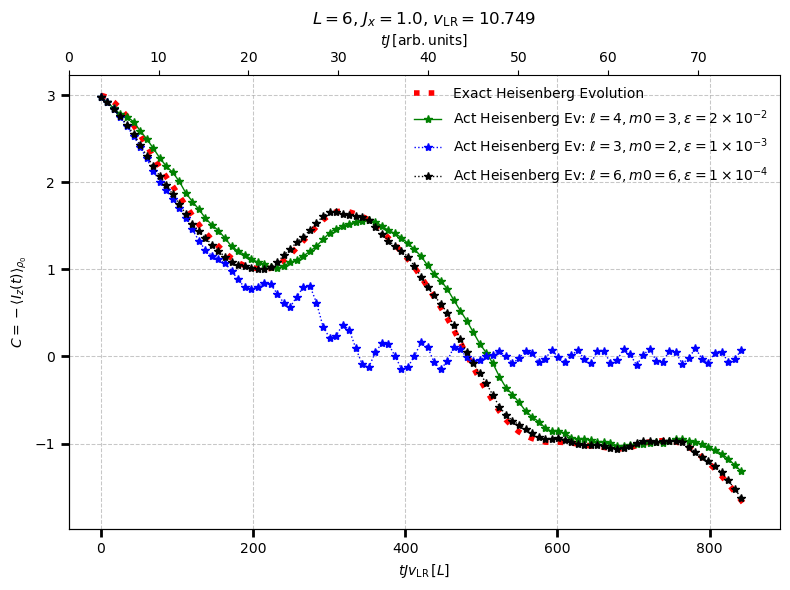

In [120]:
import matplotlib.pyplot as plt

system.spec["graph"].draw(plt)

# Création de la figure et de l'axe
fig, ax = plt.subplots(figsize=(8, 6))

# Tracés des courbes OTOC
ax.plot(timespan * vLR, res_exact.expect[0], label=r'Exact Heisenberg Evolution', color='red', ls='dotted', linewidth=4)
ax.plot(timespan[:-1] * vLR, expt_vals, label=r'Act Heisenberg Ev: $\ell=4, m0=3, \varepsilon=2\times10^{-2}$', 
        color='green', linestyle='-', marker='*', linewidth=1)

ax.plot(timespan[:-1] * vLR, expt_vals2, label=r'Act Heisenberg Ev: $\ell=3, m0=2, \varepsilon=1\times10^{-3}$',
        color='blue', linestyle=':', marker='*', linewidth=1)

ax.plot(timespan[:-1] * vLR, expt_vals3, label=r'Act Heisenberg Ev: $\ell=6, m0=6, \varepsilon=1\times10^{-4}$',
        color='black', linestyle=':', marker='*', linewidth=1)


# Bordures uniquement à gauche et en bas (style minimaliste)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Personnalisation des ticks
ax.tick_params(direction='out', length=6, width=2, which='major')
ax.grid(True, which='major', linestyle='--', linewidth=0.75, alpha=0.7)

# Ajout de la légende
ax.legend(frameon=False, loc='upper right')

# Axe x supplémentaire avec une autre échelle
ax1 = ax.twiny()
ax1.set_xlim(timespan[0], timespan[-1])

# Ajout des étiquettes aux axes
ax.set_xlabel(r'$tJ v_{\rm LR} \, [L]$')
ax1.set_xlabel(r'$tJ \, [{\rm arb. units}]$')
ax.set_ylabel(r"$C = -\langle I_z(t) \rangle_{\rho_{0}}$")

# Titre personnalisé avec des paramètres dynamiques
plt.title(r'$L={}$, $J_x={}$, $v_{{\rm LR}}={}$'.format(
    params['size'], 
    round(params['Jx'], 3), 
    round(vLR, 3)
))

# Affichage de la figure
plt.tight_layout()
plt.show()


In [ ]:
expt_vals[0]

In [26]:
qutip.expect(Iz.to_qutip(), sigma0.to_qutip())

2.999727612787786

### Scrambling: OTOC evolution 

In [110]:
W=sz_ops[0].to_qutip(); V=sz_ops[3].to_qutip()
propagators = [(-1j * H.to_qutip() * t).expm() for t in timespan]
rho_th=(-beta * H.to_qutip()).expm()
otoc=np.array([-qutip.expect(me.commutator(propagator_timet.dag() * W * propagator_timet, V)**2, rho_th) 
               for propagator_timet in propagators])

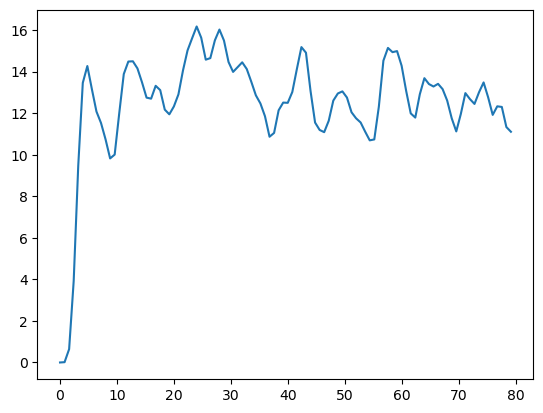

In [111]:
plt.plot(timespan, otoc)

In [112]:
def adaptive_Heisenberg_simulation_otoc(generator, rho0, tlist, simulation_params):
    local_bound_error=[]; saved_cut_times_index=[]; 
    no_acts=[0]; otoc_at_timet=[]; 
    local_t_value=.0
    
    local_seed_op=simulation_params["obs"]; local_ell=simulation_params["depth"]; 
    local_tol=simulation_params["tol"]; local_nmax=simulation_params["nmax"]
    
    sp_local=me.fetch_covar_scalar_product(sigma=rho0)
    HBB_ell_act=me.build_Hierarch(generator=generator, seed_op=local_seed_op, deep=local_ell)
    orth_basis_act=me.orthogonalize_basis(basis=HBB_ell_act, sp=sp_local)
    Hij_tensor_act=me.fn_Hij_tensor(generator=generator, basis=orth_basis_act, sp=sp_local)
    
    phi0_proj_act=me.project_op(local_seed_op, orth_basis_act, sp_local)
    phi_at_timet=[phi0_proj_act]; 
    
    otoc_at_timet.append(-qutip.expect(me.commutator(local_seed_op, V)**2, rho_th))
    
    for t in timespan[1:]:
        phi_local=np.real( linalg.expm(Hij_tensor_act * (t-local_t_value)) @ phi0_proj_act )
        local_seed_op = me.Kstate_from_phi_basis(phi=phi_local, basis=orth_basis_act)
        otoc_at_timet.append(-qutip.expect(me.commutator(local_seed_op, V)**2, rho_th))
        
        local_bound_error.append(
            me.m_th_partial_sum(phi=phi_local, m=2)/me.m_th_partial_sum(phi=phi_local, m=0)
        )
        
        if abs(local_bound_error[-1]) >= local_tol:
            no_acts.append(no_acts[-1] + 1)
            if list(timespan).index(t)%30==0:
                print("Actualization at time t=", t)
            local_t_value=t; saved_cut_times_index.append(list(timespan).index(t))
            
            HBB_ell_act=me.build_Hierarch(generator=generator, seed_op=local_seed_op,
                                                          deep=local_ell)
            HBB_ell_act=[project_to_n_body_operator(one_body_from_qutip_operator(op), nmax=local_nmax)
                             for op in HBB_ell_act]
            
            HBB_ell_act=[op.to_qutip() for op in HBB_ell_act]
            orth_basis_act=me.orthogonalize_basis(basis=HBB_ell_act, sp=sp_local)
            Hij_tensor_act=me.fn_Hij_tensor(generator=generator, basis=orth_basis_act, sp=sp_local)
    
            phi0_proj_act=me.project_op(local_seed_op, orth_basis_act, sp_local)
        else:
            no_acts.append(no_acts[-1])
    
    return phi_at_timet, otoc_at_timet

In [113]:
simulation_params={}
simulation_params["obs"]=W; simulation_params["depth"]=4; 
simulation_params["tol"]=2e-2; simulation_params["nmax"]=3

phi_at_timet1, expt_vals1=adaptive_Heisenberg_simulation_otoc(generator=H.to_qutip(), 
                                                      rho0=rho_th,
                                                      tlist=timespan, 
                                                      simulation_params=simulation_params)

Actualization at time t= 23.965427565855354
Actualization at time t= 47.93085513171071
Actualization at time t= 71.89628269756606


In [114]:
simulation_params={}
simulation_params["obs"]=W; simulation_params["depth"]=3; 
simulation_params["tol"]=1e-4; simulation_params["nmax"]=2

phi_at_timet2, expt_vals2=adaptive_Heisenberg_simulation_otoc(generator=H.to_qutip(), 
                                                      rho0=rho_th,
                                                      tlist=timespan, 
                                                      simulation_params=simulation_params)

Actualization at time t= 23.965427565855354
Actualization at time t= 47.93085513171071
Actualization at time t= 71.89628269756606


In [115]:
simulation_params={}
simulation_params["obs"]=W; simulation_params["depth"]=6; 
simulation_params["tol"]=1e-4; simulation_params["nmax"]=6

phi_at_timet3, expt_vals3=adaptive_Heisenberg_simulation_otoc(generator=H.to_qutip(), 
                                                      rho0=rho_th,
                                                      tlist=timespan, 
                                                      simulation_params=simulation_params)

Actualization at time t= 23.965427565855354
Actualization at time t= 47.93085513171071
Actualization at time t= 71.89628269756606


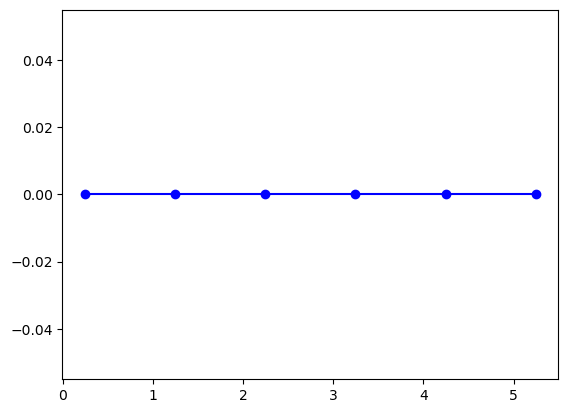

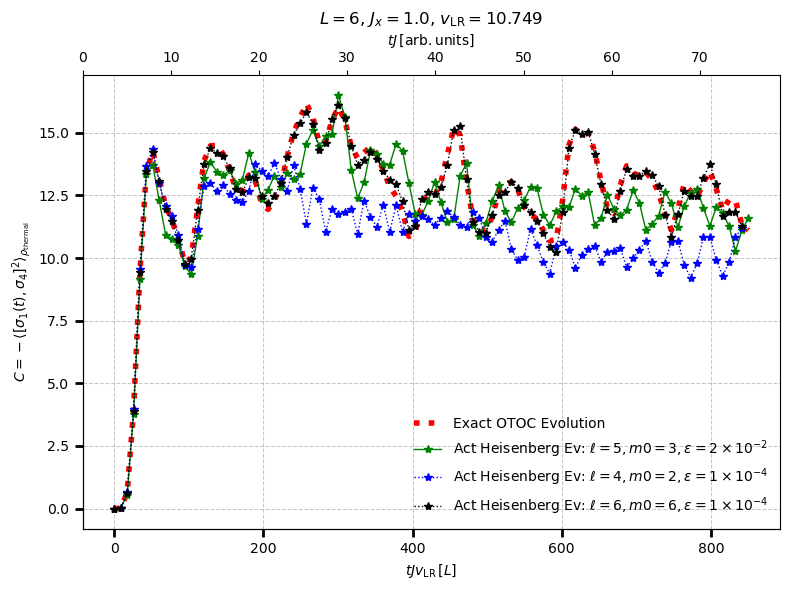

In [116]:
import matplotlib.pyplot as plt

system.spec["graph"].draw(plt)

# Création de la figure et de l'axe
fig, ax = plt.subplots(figsize=(8, 6))

# Tracés des courbes OTOC
ax.plot(timespan * vLR, otoc, label=r'Exact OTOC Evolution', color='red', ls='dotted', linewidth=4)
ax.plot(timespan * vLR, expt_vals1, label=r'Act Heisenberg Ev: $\ell=5, m0=3, \varepsilon=2\times10^{-2}$', 
        color='green', linestyle='-', marker='*', linewidth=1)

ax.plot(timespan[:-1] * vLR, expt_vals2[:-1], label=r'Act Heisenberg Ev: $\ell=4, m0=2, \varepsilon=1\times10^{-4}$',
        color='blue', linestyle=':', marker='*', linewidth=1)


ax.plot(timespan[:-1] * vLR, expt_vals3[:-1], label=r'Act Heisenberg Ev: $\ell=6, m0=6, \varepsilon=1\times10^{-4}$',
        color='black', linestyle=':', marker='*', linewidth=1)


# Bordures uniquement à gauche et en bas (style minimaliste)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Personnalisation des ticks
ax.tick_params(direction='out', length=6, width=2, which='major')
ax.grid(True, which='major', linestyle='--', linewidth=0.75, alpha=0.7)

# Ajout de la légende
ax.legend(frameon=False, loc='lower right')

# Axe x supplémentaire avec une autre échelle
ax1 = ax.twiny()
ax1.set_xlim(timespan[0], timespan[-1])

# Ajout des étiquettes aux axes
ax.set_xlabel(r'$tJ v_{\rm LR} \, [L]$')
ax1.set_xlabel(r'$tJ \, [{\rm arb. units}]$')
ax.set_ylabel(r"$C = -\langle [\sigma_{1}(t), \sigma_{4}]^2 \rangle_{\rho_{\mathrm{thermal}}}$")

# Titre personnalisé avec des paramètres dynamiques
plt.title(r'$L={}$, $J_x={}$, $v_{{\rm LR}}={}$'.format(
    params['size'], 
    round(params['Jx'], 3), 
    round(vLR, 3)
))

# Affichage de la figure
plt.tight_layout()
plt.show()


In [68]:
otoc[0]

-0.0

In [71]:
expt_vals2[0]

-0.0

In [ ]:
a